# Figure 5 

## Comparing RDD for different network sizes

Imports

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rand
import pandas as pd
import seaborn as sns

from lib.lif import LIF, ParamsLIF
from lib.causal import causaleffect_maxv, causaleffect_maxv_linear, causaleffect_maxv_sp

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [58]:
def alignment(a,b):    
    da = np.dot(a,a)
    db = np.dot(b,b)
    if da > 0 and db > 0:
        angle = 180/np.pi*np.arccos(np.dot(a,b)/np.sqrt(da*db))
        if angle > 90:
            angle = 180 - angle
        return angle
    else:
        return 360.
    
def mse(pred,true):
    return np.mean((pred - true)**2)

def tsplot(ax, data, xvals = None, label = None, **kw):
    if xvals is not None:
        x = xvals
    else:
        x = np.arange(data.shape[1])
    n = data.shape[0]
    est = np.mean(data, axis=0)
    sd = np.std(data, axis=0)/np.sqrt(n)
    cis = (est - sd, est + sd)
    ax.fill_between(x,cis[0],cis[1],alpha=0.2, label = '_nolegend_', **kw)
    if label is not None:
        ax.plot(x,est,label = label, **kw)
    else:
        ax.plot(x,est,**kw)        
    ax.margins(x=0)

In [ ]:
nsims = 100
cvals = np.array([0.01, 0.25, 0.5, 0.75, 0.99])
Nvals = np.logspace(1, 3, 4, dtype = int)
tau_s = 0.020
dt = 0.001
t = 100
sigma = 10
x = 0
p = 0.1
DeltaT = 20
target = 0.1
W = 10*np.ones(int(Nvals[-1]))
V = np.random.randn(int(Nvals[-1]))*5
cost = lambda s,a: np.sqrt((np.dot(a[0:len(s)], s) - target)**2)

## A. Dependence on $N$ and $c$

In [19]:
params = ParamsLIF(sigma = sigma)

t_filter = np.linspace(0, 1, 2000)
exp_filter = np.exp(-t_filter/tau_s)
exp_filter = exp_filter/np.sum(exp_filter)
ds = exp_filter[0]

beta_mse_rd_c = np.zeros((len(cvals), len(Nvals), nsims))
beta_mse_fd_c = np.zeros((len(cvals), len(Nvals), nsims))
beta_mse_bp_c = np.zeros((len(cvals), len(Nvals), nsims))

beta_mse_rd_c_linear = np.zeros((len(cvals), len(Nvals), nsims))
beta_mse_fd_c_linear = np.zeros((len(cvals), len(Nvals), nsims))

In [47]:
mean_beta_c = np.zeros((len(cvals), len(Nvals), nsims))
mean_beta_fd_c = np.zeros((len(cvals), len(Nvals), nsims))

mean_beta_aln_c = np.zeros((len(cvals), len(Nvals), nsims))
mean_beta_aln_fd_c = np.zeros((len(cvals), len(Nvals), nsims))

for j, n_units in enumerate(Nvals):    

    #Run but with no noise to get true causal effect
    params.c = 0.001
    params.n = n_units
    lif = LIF(params, t = t)
    lif.W = W[0:n_units]
    (v, h, _, _, u) = lif.simulate(DeltaT)
    s = np.zeros(h.shape)
    for l in range(n_units):
        s[l,:] = np.convolve(h[l,:], exp_filter)[0:h.shape[1]]
    cost_s = cost(s,V[0:n_units])                
    beta_true_c = causaleffect_maxv(u, cost_s, DeltaT, 1, params)            

    for i,c in enumerate(cvals):
        print("Running %d simulations with c=%s, n=%d"%(nsims, c, n_units))
        params.c = c
        params.n = n_units
        lif = LIF(params, t = t)
        lif.W = W[0:n_units]
        for k in range(nsims):
            (v, h, _, _, u) = lif.simulate(DeltaT)
            s = np.zeros(h.shape)
            for l in range(n_units):
                s[l,:] = np.convolve(h[l,:], exp_filter)[0:h.shape[1]]
            cost_s = cost(s,V[0:n_units])                
            beta_est_c = causaleffect_maxv(u, cost_s, DeltaT, p, params)
            beta_est_fd_c = causaleffect_maxv(u, cost_s, DeltaT, 1, params)
           
            mean_beta_c[i,j,k] = mse(beta_est_c[0], beta_true_c[0])
            mean_beta_fd_c[i,j,k] = mse(beta_est_fd_c[0], beta_true_c[0])

            mean_beta_aln_c[i,j,k] = alignment(beta_est_c, beta_true_c)
            mean_beta_aln_fd_c[i,j,k] = alignment(beta_est_fd_c, beta_true_c)

Running 100 simulations with c=0.01, n=10
Running 100 simulations with c=0.25, n=10
Running 100 simulations with c=0.5, n=10
Running 100 simulations with c=0.75, n=10
Running 100 simulations with c=0.99, n=10
Running 100 simulations with c=0.01, n=46
Running 100 simulations with c=0.25, n=46
Running 100 simulations with c=0.5, n=46
Running 100 simulations with c=0.75, n=46
Running 100 simulations with c=0.99, n=46
Running 100 simulations with c=0.01, n=215
Running 100 simulations with c=0.25, n=215
Running 100 simulations with c=0.5, n=215
Running 100 simulations with c=0.75, n=215
Running 100 simulations with c=0.99, n=215
Running 100 simulations with c=0.01, n=1000
Running 100 simulations with c=0.25, n=1000
Running 100 simulations with c=0.5, n=1000
Running 100 simulations with c=0.75, n=1000
Running 100 simulations with c=0.99, n=1000


Use seaborn for plotting

In [80]:
from itertools import product
for i, j, k in product(*[range(i) for i in mean_beta_aln_fd_c.shape]):
    if mean_beta_aln_fd_c[i,j,k] > 90:
        mean_beta_aln_fd_c[i,j,k] = 180 - mean_beta_aln_fd_c[i,j,k]

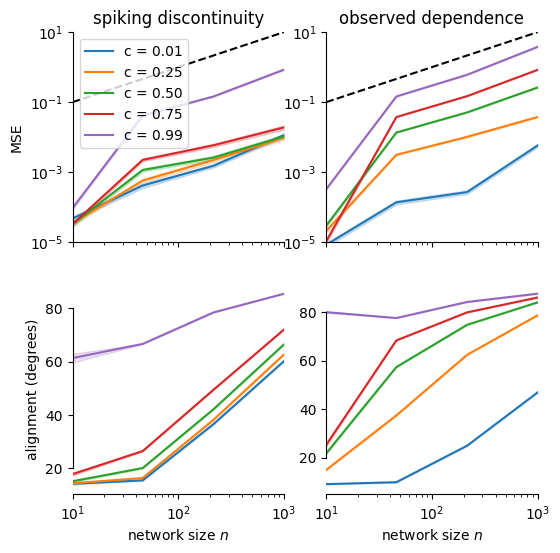

In [83]:
fig,axes = plt.subplots(2,2,figsize=(6,6), sharex = True)
pal = sns.color_palette()
for i in range(len(cvals)):
    cval = cvals[i]
    tsplot(data = mean_beta_c[i,:,:].T, ax = axes[0,0], color = pal[i], xvals = Nvals, label = f"c = {cval:.2f}")
    tsplot(data = mean_beta_fd_c[i,:,:].T, ax = axes[0,1], color = pal[i], xvals = Nvals, label = f"c = {cval:.2f}")
    tsplot(data = mean_beta_aln_c[i,:,:].T, ax = axes[1,0], color = pal[i], xvals = Nvals)
    tsplot(data = mean_beta_aln_fd_c[i,:,:].T, ax = axes[1,1], color = pal[i], xvals = Nvals)

axes[0,0].plot([10, 1000], [1e-1, 1e1], color = 'black', linestyle = '--')
axes[0,1].plot([10, 1000], [1e-1, 1e1], color = 'black', linestyle = '--')
axes[1,0].set_xlabel('network size $n$');
axes[1,1].set_xlabel('network size $n$');
axes[0,0].set_ylabel('MSE');
axes[1,0].set_ylabel('alignment (degrees)');
axes[0,0].set_title('spiking discontinuity');
axes[0,1].set_title('observed dependence');
axes[0,0].set_xscale('log')
axes[0,1].set_xscale('log')
axes[0,0].set_ylim([1e-5, 1e1])
axes[0,1].set_ylim([1e-5, 1e1])
axes[1,0].set_xscale('log')
axes[1,1].set_xscale('log')
axes[0,0].set_yscale('log')
axes[0,1].set_yscale('log')
sns.despine(trim=True)
axes[0,0].legend(loc = 'upper left');
plt.savefig('./fig_5_networksize_mse.pdf')

In [82]:
## Save results
import pickle

to_save = {'mean_beta_c': mean_beta_c,
           'mean_beta_fd_c': mean_beta_fd_c,
           'mean_beta_aln_c': mean_beta_aln_c,
           'mean_beta_aln_fd_c': mean_beta_aln_fd_c}
fn_out = './fig_5_networksize_results.pkl'

with open(fn_out, 'wb') as handle:
    pickle.dump(to_save, handle, protocol=pickle.HIGHEST_PROTOCOL)
